[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/atmos-cloud-sim-uj/PySDM-examples.git/main?urlpath=PySDM_examples/Lowe_et_al_2019/fig_3.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/atmos-cloud-sim-uj/PySDM-examples/blob/main/PySDM_examples/Lowe_et_al_2019/fig_3.ipynb)

#### based on Fig. 3 from Lowe et al. 2019 (Nature Comm.)  "_Key drivers of cloud response to surface-active organics_"   
https://doi.org/10.1038/s41467-019-12982-0

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install PySDM-examples \
      notebook==`python -c "import notebook; print(notebook.__version__)"` \
      tornado==`python -c "import tornado; print(tornado.version)"`
    !ldconfig

In [3]:
from PySDM_examples.Lowe_et_al_2019 import Settings, Simulation
from PySDM_examples.Lowe_et_al_2019.aerosol import AerosolMarine, AerosolBoreal
from atmos_cloud_sim_uj_utils import show_plot
from PySDM.physics.spectra import Lognormal
from PySDM.initialisation import spectral_sampling as spec_sampling
from PySDM.physics import si
import numpy as np
from matplotlib import pyplot
import matplotlib

In [4]:
# updraft_list = np.geomspace(0.1,10,2)
# forg_list = np.linspace(0.1,0.9,3)
# subplot_list = ["a","b","c","d"]

updraft_list = np.geomspace(0.1,10,5)
forg_list = np.linspace(0.1,0.9,7)
subplot_list = ["a","b","c","d"]
#subplot_list = ["b"]

output = {}

for model in ('bulk','film'):
    for subplot in subplot_list:
        print(subplot, model)
        for w in updraft_list:
            for Forg in forg_list:
                aerosol_list = {"a": AerosolMarine(Acc_Forg=Forg, Acc_N2=30), 
                                "b": AerosolMarine(Acc_Forg=Forg, Acc_N2=134), 
                                "c": AerosolBoreal(Acc_Forg=Forg, Acc_N2=160), 
                                "d": AerosolBoreal(Acc_Forg=Forg, Acc_N2=540)}
                aerosol = aerosol_list[subplot]
                key = subplot+"_w{:.2f}_f{:.2f}_".format(w,Forg)+model
                #print(key)
                settings = Settings(
                    dt=1*si.s, n_sd_per_mode=128, 
                    model=model,
                    aerosol=aerosol,
                    w=w * si.m / si.s,
                    spectral_sampling=spec_sampling.ConstantMultiplicity
                )
                settings.output_interval = 2 * si.s
                simulation = Simulation(settings)
                output[key] = simulation.run()
                output[key]['updraft'] = w
                output[key]['org_fraction'] = Forg
                output[key]['color'] = aerosol.color

a bulk
b bulk
c bulk
d bulk
a film
b film
c film
d film


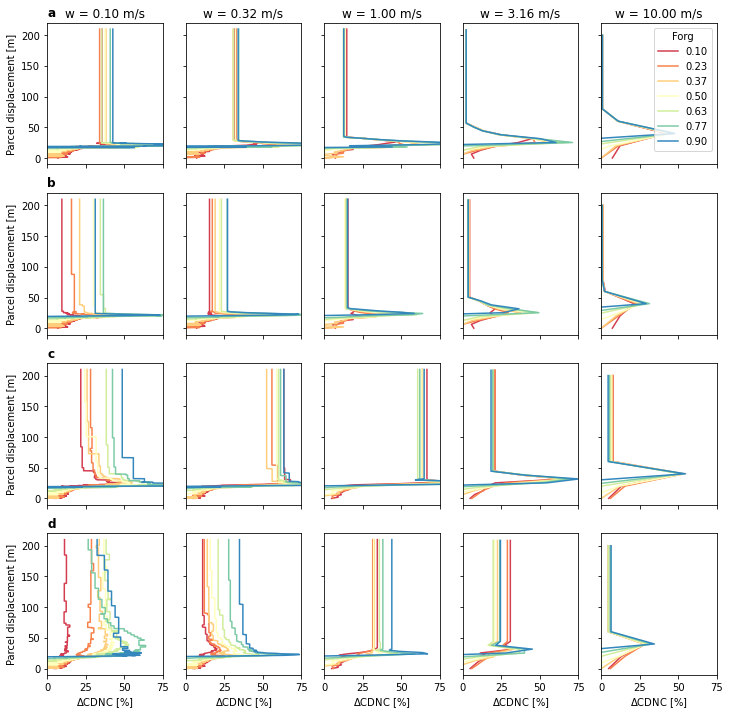

In [50]:
fig,axes = pyplot.subplots(len(subplot_list),len(updraft_list), sharex=True, sharey=True, figsize=(12,12))

for k,subplot in enumerate(subplot_list):
    for i,w in enumerate(updraft_list):
        for j,Forg in enumerate(forg_list):
                key = subplot+"_w{:.2f}_f{:.2f}_".format(w,Forg)
                var = 'n_c_cm3'
                z = np.array(output[key+"film"]['z'])
                CDNC_film = np.array(output[key+"film"][var])
                CDNC_bulk = np.array(output[key+"bulk"][var])
                
                cmap = matplotlib.cm.get_cmap('Spectral')
                #pyplot.plot(CDNC_film, z, "--", color=cmap(Forg))
                #pyplot.plot(CDNC_bulk, z, "-", color=cmap(Forg), label="{:.2f}".format(Forg))
                ax = axes[k,i]
                ax.plot((CDNC_film - CDNC_bulk) / CDNC_bulk * 100, z, "-", color=cmap(Forg), label="{:.2f}".format(Forg))
                if i == 0:
                    ax.set_ylabel("Parcel displacement [m]")
                    ax.set_title(subplot, loc="left", weight="bold")
                if i == len(updraft_list)-1 and k == 0:
                    ax.legend(title="Forg", loc=1)
                if k == 0:
                    ax.set_title("w = {:.2f} m/s".format(w))
                if k == len(subplot_list)-1:
                    ax.set_xlabel("$\Delta$CDNC [%]")
                    ax.set_xlim([0,75])
pyplot.savefig("fig3-parcel-profiles.png",dpi=200)
pyplot.show()

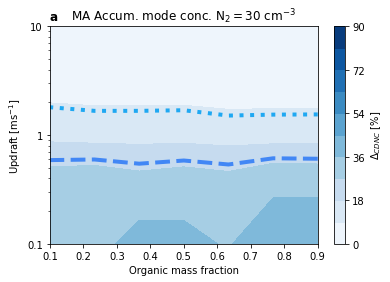

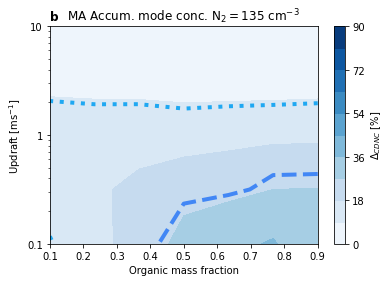

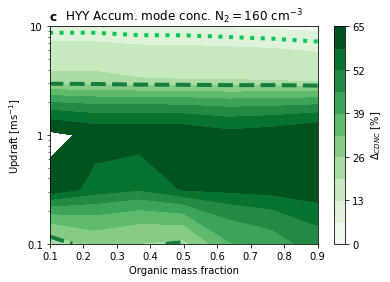

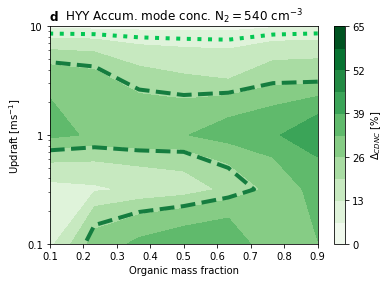

In [16]:
for subplot in subplot_list:
    dCDNC = np.zeros((len(updraft_list), len(forg_list)))
    for i,w in enumerate(updraft_list):
        for j,Forg in enumerate(forg_list):
            key = subplot+"_w{:.2f}_f{:.2f}_".format(w,Forg)
            var = 'n_c_cm3'
            z = np.array(output[key+"film"]['z'])
            wz = np.where(z == z[-1])[0][0]
            CDNC_film = np.array(output[key+"film"][var])[wz]
            CDNC_bulk = np.array(output[key+"bulk"][var])[wz]
            dCDNC[i,j] = (CDNC_film - CDNC_bulk) / CDNC_bulk * 100.0
            #print(w, Forg, CDNC_bulk, CDNC_film, dCDNC[i,j])

    if subplot == "a" or subplot == "b":
        pyplot.contour(forg_list, updraft_list, dCDNC, levels=[10,25], colors=["#1fa8f2","#4287f5"], 
                       linestyles=[":","--"], linewidths=4)
        pyplot.contourf(forg_list, updraft_list, dCDNC, cmap="Blues", levels=np.linspace(0,90,11))
        if subplot == "a":
            pyplot.title("MA Accum. mode conc. N$_2 = 30$ cm$^{-3}$")
        else:
            pyplot.title("MA Accum. mode conc. N$_2 = 135$ cm$^{-3}$")
    if subplot == "c" or subplot == "d":
        pyplot.contour(forg_list, updraft_list, dCDNC, levels=[10,25], colors=["#04c753","#157d3f"], 
                       linestyles=[":","--"], linewidths=4)
        pyplot.contourf(forg_list, updraft_list, dCDNC, cmap="Greens", levels=np.linspace(0,65,11))
        if subplot == "c":
            pyplot.title("HYY Accum. mode conc. N$_2 = 160$ cm$^{-3}$")
        else:
            pyplot.title("HYY Accum. mode conc. N$_2 = 540$ cm$^{-3}$")

    pyplot.title(subplot,weight="bold",loc="left")
    pyplot.xlabel("Organic mass fraction")
    pyplot.yscale("log")
    pyplot.yticks([0.1,1,10],["0.1","1","10"])
    pyplot.ylabel("Updraft [ms$^{-1}$]")
    pyplot.colorbar(label="$\Delta_{CDNC}$ [%]")
    pyplot.savefig("fig3"+subplot+".png", dpi=200)
    pyplot.show()
    #show_plot()